In [38]:
from transformers import pipeline
from PIL import Image, ImageFilter
import requests
import matplotlib.pyplot as plt
import pytesseract
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as transforms
import numpy as np
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

from non_exact_match import lcs, levenshtein_dist, tools

/home/davialvb/.pyenv/versions/ocr_testes/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# load QA model to test
nlp = pipeline(
    "document-question-answering",
    model="impira/layoutlm-document-qa",
)

In [4]:
# load image
url = "https://thumbs.jusbr.com/imgs.jusbr.com/publications/noticias/images/documento-unico1491909891.jpeg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

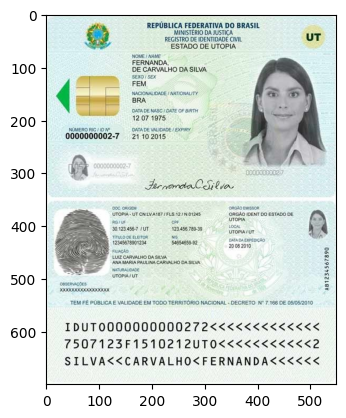

In [5]:
plt.imshow(image)

In [12]:
nlp(
    image,
    "What is the nationality?"
)

[{'score': 0.9819023609161377, 'answer': 'BRASIL', 'start': 3, 'end': 3}]

In [13]:
def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

In [14]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [195]:
def get_text_from_image(image, lang="por"):
    document_text, document_boxes_normalized, document_boxes = apply_tesseract(image, lang)
    word_boxes = dict(zip(document_text, document_boxes))
    return " ".join(document_text), document_boxes, word_boxes

In [196]:
def apply_tesseract(image: "Image.Image", lang: "por"):
    data = pytesseract.image_to_data(image, lang=lang, output_type="dict")
    words, left, top, width, height = data["text"], data["left"], data["top"], data["width"], data["height"]

    irrelevant_indices = [idx for idx, word in enumerate(words) if not word.strip()]
    words = [word for idx, word in enumerate(words) if idx not in irrelevant_indices]
    left = [coord for idx, coord in enumerate(left) if idx not in irrelevant_indices]
    top = [coord for idx, coord in enumerate(top) if idx not in irrelevant_indices]
    width = [coord for idx, coord in enumerate(width) if idx not in irrelevant_indices]
    height = [coord for idx, coord in enumerate(height) if idx not in irrelevant_indices]

    actual_boxes = []
    for x, y, w, h in zip(left, top, width, height):
        actual_box = [x, y, x + w, y + h]
        actual_boxes.append(actual_box)

    image_width, image_height = image.size

    normalized_boxes = []
    for box in actual_boxes:
        normalized_boxes.append(normalize_box(box, image_width, image_height))

    if len(words) != len(normalized_boxes):
        raise ValueError("Not as many words as there are bounding boxes")

    return words, normalized_boxes, actual_boxes

In [201]:
def match_text_in_image(user_input, user_input_2):
    user_input_2_normalized = tools.string_normalize(user_input_2)
    user_input_normalized = tools.string_normalize(user_input)

    user_input_lenth = len(user_input.split(" "))
    ngram_input = tools.generate_ngrams(user_input_2_normalized, ngram=user_input_lenth)


    longest = 999
    longest_lcs = 0
    accepted_lcs = 85
    for ngram in ngram_input:
        err = levenshtein_dist.edit_distance(ngram, user_input_normalized)
        text_result, start, end, lcs_result = lcs.lcsubstring(user_input_normalized, ngram)
        if err < longest:
            longest = err
            ngram_result = ngram
        if lcs_result > longest_lcs:
            ngram_result_lcs = ngram
            longest_lcs = lcs_result
            text_result_f, start_f, end_f, lcs_result_f = text_result, start, end, lcs_result
            err_lcs = levenshtein_dist.edit_distance(ngram_result_lcs, user_input_normalized)
            
    alignments = pairwise2.align.localxx(ngram_result_lcs, user_input_normalized)
    for a in alignments:
        print(format_alignment(*a))
    
    if ngram_result_lcs == ngram_result: 
        return ngram_result_lcs
    else:
        if err_lcs>err:
            return ngram_result
        else:
            return ngram_result_lcs

In [222]:
def get_unnormalized_boxes(image, boxes):
    unnormalized_boxes = []
    image_width, image_height = image.size
    for box in boxes:
        unnormalized_boxes.append(unnormalize_box(box, image_width, image_height))
    return unnormalized_boxes

In [197]:
image_binarized = image.convert('L')
image_binarized = image_binarized.point( lambda p: 255 if p > 170 else 0 )
image_binarized = image_binarized.convert('1')
image_binarized.show()

In [121]:
img_gray = image.convert("L")
edges = img_gray.filter(ImageFilter.FIND_EDGES)
edges = edges.convert('1')
edges.show()

In [122]:
img_gray_smooth = img_gray.filter(ImageFilter.SMOOTH)
edges_smooth = img_gray_smooth.filter(ImageFilter.FIND_EDGES)
edges_smooth.show()

In [182]:
image_to_text = image

In [198]:
document_text, document_boxes, word_boxes = get_text_from_image(image_to_text)

In [199]:
user_input = "FERNANDA DE CARVALHO DA SILVA"

In [200]:
user_input_2 = document_text

In [202]:
match_result = match_text_in_image(user_input, user_input_2)

6 fernanda de carvalho da-silva
  ||||||||||||||||||||||| |||||
1 fernanda de carvalho da silva
  Score=28



In [203]:
user_input

'FERNANDA DE CARVALHO DA SILVA'

In [204]:
match_result

'mave fernanda de carvalho dasilva'

In [205]:
user_input_2

'REPÚBLICA FEDERATIVA DO BRASIL 8 MINISTÉRIO DA JUSTIÇA. REGISTRO DE IDENTIDADE CML ESTADO DE UTOPIA nove mave FERNANDA, DE CARVALHO DASILVA sexo sex FEM NACIONALIDADE MAmomaTY. BRA ORTADENASO DATE OF BIRTH 12071975 DATA DE VALOR DE VEXPRY. NQuERO RG 1070 0000000002-7 21102015 A ANA errando Silo ooe oncou UTOPIA-UTONIVAIE? FLS 42 Mora antzresea dum taasa tado ÉS, rzsaseregorzãs E ruição ue CAraHO DA SINA. ARMAR PAULINA CARVALHO DA SINA uropujur ossemições ex one tuo ORGão IDENT DO Estado DE ÚroPA vropurur omoneeoção 29082010 D aBI234s67890 TEM FÉ PÚBLICA E VALIDADE EM TODO TERRITÓRIO NACIONAL DECRETO Nº 7.165 DE Osios2010 IDUTO0O00000000272<<<<<<<<<<<<< 7507123F1510212U0TO<<<<<<<<<<<2 SILVA<<CARVALHO<SFERNANDA<<<<<<'

In [225]:
user_input in user_input_2

False

In [207]:
user_input_2_normalized = tools.string_normalize(user_input_2)

In [226]:
save_boxes = []
match_result_splited = match_result.split()

for word, box in word_boxes.items():
    if match_result_splited:
        if tools.string_normalize(word) in match_result_splited:
            print(word, match_result_splited)
            save_boxes.append(box)
#             match_result_splited.pop(0)

DE ['mave', 'fernanda', 'de', 'carvalho', 'dasilva']
mave ['mave', 'fernanda', 'de', 'carvalho', 'dasilva']
FERNANDA, ['mave', 'fernanda', 'de', 'carvalho', 'dasilva']
CARVALHO ['mave', 'fernanda', 'de', 'carvalho', 'dasilva']
DASILVA ['mave', 'fernanda', 'de', 'carvalho', 'dasilva']


In [227]:
save_boxes

[[441, 543, 454, 550],
 [194, 76, 216, 83],
 [163, 87, 232, 98],
 [205, 466, 292, 474],
 [252, 100, 304, 110]]

In [223]:
box = torch.tensor(save_boxes)

transform = transforms.Compose([
    transforms.PILToTensor()
])

img_tensor = transform(image)
img_tensor = draw_bounding_boxes(img_tensor, box, width=1, fill=True)
img_tensor = torchvision.transforms.ToPILImage()(img_tensor)
img_tensor.show()

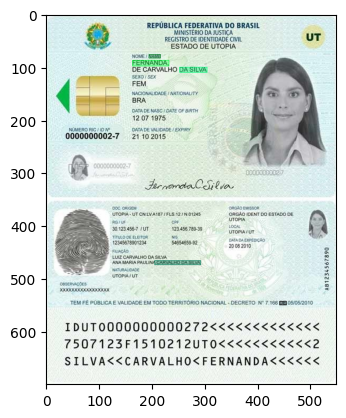

In [224]:
plt.imshow(img_tensor)